<a href="https://colab.research.google.com/github/NickKar30/GM-HSE-AI-masters-course/blob/main/Hometasks/Base/GenDL_HT1_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание - 1 (базовая группа)

В этом домашнем задании вы потренируетесь решать задачу speech-to-text.

Вы не будете тренировать сложную архитектуру с нуля, а попробуете решить эту задачу, пройдя по пайплайну, в котором задача разбита на несколько простых шагов.

- В этом задании мы призываем вас по-максимуму использовать документацию моделей и получить опыт написания кода без заготовок

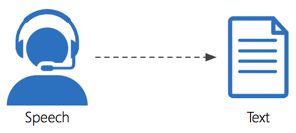

In [14]:
!pip install evaluate -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [61]:
import pandas as pd

## Шаг 1 (1 балл)

* Возьмите датасет https://disk.yandex.ru/d/v2Hipv7XG4fEDQ, содержащий русскоязычные аудиозаписи

* Примените модель [whisper-small](https://huggingface.co/openai/whisper-small) из HF для определения сказанного в аудио.

* Выведите результат работы модели для 10 случайных аудио из датасета

Не стесняйтесь пользоваться документацией и источниками знаний из интернета!

In [2]:
urls = []
with open('urls_normalized.tsv', 'r') as f:
    for line in f:
        line = line.strip()
        urls.append(line)

In [3]:
import numpy as np
import torch
import torchaudio
from transformers import WhisperForConditionalGeneration, WhisperProcessor

In [5]:
!pip install librosa soundfile

  Using cached librosa-0.11.0-py3-none-any.whl.metadata (8.7 kB)
  Using cached audioread-3.0.1-py3-none-any.whl.metadata (8.4 kB)
  Using cached pooch-1.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
Using cached librosa-0.11.0-py3-none-any.whl (260 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.5 MB/s  0:00:00 eta 0:00:01
Using cached audioread-3.0.1-py3-none-any.whl (23 kB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 11.5 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 9.5 MB/s  0:00:03m0:00:0100:01m
Using cached pooch-1.8.2-py3-none-any.whl (64 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9/9 [librosa]m7/9 [numba]te]


In [62]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration

def recognize_audio(processor: WhisperProcessor, model_w: WhisperForConditionalGeneration, url: str):
    response = requests.get(url, timeout=30)
    response.raise_for_status()
        
    temp_filename = f"temp_audio_{hash(url)}.wav"
    with open(temp_filename, 'wb') as f:
        f.write(response.content)
        
    wav, sr = librosa.load(temp_filename, sr=16000)
    wav = torch.from_numpy(wav).unsqueeze(0)
    if wav.shape[0] > 1:
        wav = wav.mean(dim=0, keepdim=True)

    if os.path.exists(temp_filename):
        os.remove(temp_filename)
                
    input_features = processor(wav.squeeze().numpy(), sampling_rate=sr, return_tensors="pt").input_features

    with torch.no_grad():
        generated_ids = model_w.generate(
            input_features,
            max_length=448,
            language="russian",
            task="transcribe"
        )
        
    return processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [65]:
import requests
import random
import os
import librosa

## https://huggingface.co/openai/whisper-small
WHISPER_MODEL_NAME = "openai/whisper-small"
processor = WhisperProcessor.from_pretrained(WHISPER_MODEL_NAME)
model = WhisperForConditionalGeneration.from_pretrained(WHISPER_MODEL_NAME)

rnd_urls = random.sample(urls, 10)

texts = []
for i, url in enumerate(rnd_urls, 1):
        transcription = recognize_audio(processor, model, url)
        print(f"Audio {i} (URL: {url}):")
        print(f"Detected text: {transcription}")
        print("-" * 50)
        texts.append(transcription)

Audio 1 (URL: http://storage.mds.yandex.net:80/get-voicetoloka/2021744/4201a552-ca79-4a67-9b2a-126d75d0a3be):
Detected text:  Римский каникул
--------------------------------------------------
Audio 2 (URL: http://storage.mds.yandex.net:80/get-voicetoloka/1872575/759edbe2-5d4f-4c88-acdc-439fcd5eb6c1):
Detected text:  Michael Fradey
--------------------------------------------------
Audio 3 (URL: http://storage.mds.yandex.net:80/get-voicetoloka/1872575/47b9b402-e832-438d-ad85-3f7375867e4a):
Detected text:  КОУ ПОРТЕР
--------------------------------------------------
Audio 4 (URL: http://storage.mds.yandex.net:80/get-voicetoloka/1872575/197f271b-b23f-4ee0-b240-e956a172d7af):
Detected text:  Жизнь других.
--------------------------------------------------
Audio 5 (URL: http://storage.mds.yandex.net:80/get-voicetoloka/1879367/163e0da8-750f-45d4-b5d5-8982fb060c12):
Detected text:  Новый кинотеатр пародизо
--------------------------------------------------
Audio 6 (URL: http://storage.mds.y

## Шаг 2 (1 балл)

Текст распознается с ошибками.
Попробуйте исправить ошибки с помощью готовой (предобученной) модели spell correction.

Выведите на экран 10 текстов с предыдущего шага и их исправления с помощью модели https://huggingface.co/UrukHan/t5-russian-spell.

In [84]:
MAX_LENGTH = 256

def correct_text(model, tokenizer, text):
    inputs = tokenizer(
        text, 
        return_tensors="pt", 
        max_length=MAX_LENGTH, 
        truncation=True,
        padding=True
    )
    with torch.no_grad():
        outputs = model.generate(
            inputs.input_ids,
            max_length=MAX_LENGTH,
            num_beams=4,
            early_stopping=True,
            do_sample=False
        )
    corrected_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return corrected_text.strip()

In [69]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

T5_MODEL_NAME = 'UrukHan/t5-russian-spell'

spell_tokenizer = AutoTokenizer.from_pretrained(T5_MODEL_NAME)
spell_model = AutoModelForSeq2SeqLM.from_pretrained(T5_MODEL_NAME)

for i, original_text in enumerate(texts, 1):
    print(f"text {i}:")
    print(f"Original: {original_text}")
    print(f"Fixed: {correct_text(spell_model, spell_tokenizer, original_text)}")
    print("-" * 50)

text 1:
Original:  Римский каникул
Fixed: Римский каникул.
--------------------------------------------------
text 2:
Original:  Michael Fradey
Fixed: Michael Fradey
--------------------------------------------------
text 3:
Original:  КОУ ПОРТЕР
Fixed: КОМУ ПОРТЕРТЕР
--------------------------------------------------
text 4:
Original:  Жизнь других.
Fixed: Жизнь других
--------------------------------------------------
text 5:
Original:  Новый кинотеатр пародизо
Fixed: Новый кинотеатр пародии
--------------------------------------------------
text 6:
Original:  Аристотель.
Fixed: Аристотель
--------------------------------------------------
text 7:
Original:  Рене-декарт.
Fixed: Рене-Декарт
--------------------------------------------------
text 8:
Original:  Смоки Робинсон
Fixed: Смоки Робинсон
--------------------------------------------------
text 9:
Original:  Мой сосед татура.
Fixed: Мой сосед Татура.
--------------------------------------------------
text 10:
Original:  Бабель И

## Шаг 3 (2 балла)

Соберите данные для дообучения модели выше. Для дообучения мы предлагаем вам использовать бесплатный api Groq: https://console.groq.com/docs/quickstart

Разберитесь с тем как пользоваться api (мы немного поможем вам с этим кодом ниже) и с его помощью соберите датасет (можно в несколько запросов).

- **0.5 балла** ставится за сбор датасета размером >1000 строк и сохранение в локальный файл/файлы

- **еще 0.5 балла** ставится за [создание huggingface dataset](https://huggingface.co/docs/datasets/create_dataset) (через использование библиотек datasets и huggingface) и [сохранение собранного датасета напрямую в HuggingFace](https://huggingface.co/docs/datasets/upload_dataset)

- **еще 1 балл** ставится за сбор датасета размером >1000 строк, на котором путем дообучения получится увеличить качество исправления опечаток в поставленной задаче (см. шаг 6) по сравнению с качеством прогноза той же, но предобученной модели

P.S. Если у Вас нет VPN, то можете воспользоваться другой LLM на Ваш выбор (можно, например, этим https://ollama.com/).

In [73]:
OLLAMA_HOST = "http://localhost:11434"
LLAMA_MODEL_NAME = "llama3.1"

try:
    response = requests.get(f"{OLLAMA_HOST}/api/tags", timeout=5)
    if response.status_code == 200:
        models = response.json().get('models', [])
        print(f"Ollama OK. Модели: {[m['name'] for m in models]}")
except Exception as e:
    print(f"Ollama NOT OK: {e}")

Ollama OK. Модели: ['llama3.1:latest']


In [74]:
def generate(prompt: str) -> str:
    response = requests.post(
        f"{OLLAMA_HOST}/api/generate",
        json={
            "model": LLAMA_MODEL_NAME,
            "prompt": prompt,
            "stream": False,
            "options": {
                "temperature": 0.7,
                "top_p": 0.9,
                "max_tokens": 512
            }
        },
        timeout=30
    )
        
    if response.status_code == 200:
        return response.json().get('response', '').strip()
    else:
        print(f"api error: {response.status_code}")
        return ""

In [75]:
prompts = [
        "Напиши 10 коротких предложений (максимум 8 слов) на русском языке с частыми опечатками, которые возникают при распознавании речи. В каждом предложении должно быть 1-2 опечатки. В ответе должны бать только предложения с ошибками. Каждое предложение с новой строки",
        
        "Создай список из 10 коротких фраз (максимум 5 слов) на русском языке с ошибками, похожими на те, что возникают при распознавании speech-to-text. Ошибки должны быть фонетическими. В ответе должны бать только предложения с ошибками. Каждое предложение с новой строки",
        
        "Напиши 10 коротких предложений (максимум 8 слов) на русском языке с опечатками, которые часто встречаются при автоматическом распознавании речи. Включи замены букв, пропуски букв, лишние буквы. В одном предложении может быть 1-2 ошибки. В ответе должны бать только предложения с ошибками. Каждое предложение с новой строки",
        
        "Создай 10 коротких текстов (максимум 8 слов) на русском языке с типичными ошибками распознавания речи: замены похожих звуков, неправильное разделение слов, фонетические искажения. В одном предложении может быть 1-2 ошибки. В ответе должны бать только предложения с ошибками. Каждое предложение с новой строки",
        
        "Напиши 10 коротких фраз (максимум 8 слов) с опечатками, имитирующими ошибки голосового ввода. Ошибки должны быть реалистичными для русского языка. В одном предложении может быть 1-2 ошибки. В ответе должны бать только предложения с ошибками. Каждое предложение с новой строки",
        
        "Создай 10 коротких предложений (максимум 8 слов) с ошибками распознавания речи: замены 'ш' на 'с', 'ч' на 'т', 'в' на 'ф', и другие типичные фонетические замены. В одном предложении может быть 1-2 ошибки. В ответе должны бать только предложения с ошибками. Каждое предложение с новой строки",
        
        "Напиши 10 коротких текстов (максимум 8 слов) с опечатками, характерными для автоматического распознавания русской речи: неправильное ударение, замена согласных, пропуски гласных. В одном предложении может быть 1-2 ошибки. В ответе должны бать только предложения с ошибками. Каждое предложение с новой строки",
        
        "Создай 10 коротких фраз (максимум 8 слов) с ошибками, похожими на те, что возникают при преобразовании речи в текст: замена похожих звуков, неправильное разбиение слов, фонетические искажения. В одном предложении может быть 1-2 ошибки. В ответе должны бать только предложения с ошибками. Каждое предложение с новой строки",
        
        "Напиши 10 коротких предложений (максимум 8 слов) на русском языке с реалистичными опечатками speech-to-text: замены 'и' на 'ы', 'о' на 'а', неправильные окончания слов. В одном предложении может быть 1-2 ошибки. В ответе должны бать только предложения с ошибками. Каждое предложение с новой строки",
        
        "Создай 10 коротких текстов (максимум 8 слов) с типичными ошибками распознавания речи: замена звонких на глухие согласные, неправильное разделение слов, фонетические замены. В одном предложении может быть 1-2 ошибки. В ответе должны бать только предложения с ошибками. Каждое предложение с новой строки"
    ]

In [76]:
from typing import List, Dict

def parse_response_text(text: str) -> List[Dict[str, str]]:
    pairs = []
    lines = text.strip().split('\n')
    
    for line in lines:
        line = line.strip()
        if not line or len(line) < 2:
            continue
            
        if line[0].isdigit() and '.' in line[:3]:
            line = line.split('.', 1)[1].strip()
        
        pairs.append({'incorrect': line, 'correct': ''})
    
    return pairs

In [77]:
import time

def collect_dataset(num_samples: int = 1200) -> List[Dict[str, str]]:
    dataset = []
        
    for i in range(len(prompts)):
        prompt_text = prompts[i]
        generated_text = generate(prompt_text)
        
        if generated_text:
            pairs = parse_response_text(generated_text)
            
            for pair in pairs:
                corrected = generate(f"Исправь опечатки в этом тексте: {pair['incorrect']} В твоем ответе должно быть только предложение, никакого другого текста")
                pair['correct'] = corrected

        if len(dataset) >= num_samples:
            break
    
    while len(dataset) < num_samples:
        generated = generate("Напиши простое короткое предложение (максимум 8 слов) на русском языке с 1-2 опечатками. В предложении может быть 1-2 ошибки. В твоем ответе должно быть только предложение, никакого другого текста")
        
        if generated:
            corrected = generate(f"Исправь опечатки: {generated} В твоем ответе должно быть только предложение, никакого другого текста")
            if corrected and generated != corrected:
                dataset.append({'incorrect': generated, 'correct': corrected})
    
    return dataset[:num_samples]

In [78]:
dataset = collect_dataset(1200)

In [79]:
print(f"\nCollected {len(dataset)} ")
    
df = pd.DataFrame(dataset)
df.to_csv('spell_dataset.csv', index=False, encoding='utf-8')


Collected 1200 


In [80]:
from datasets import Dataset

df = pd.read_csv('spell_dataset.csv')
dataset = Dataset.from_pandas(df)

In [ ]:
from huggingface_hub import HfApi, login

def upload_to_huggingface(dataset, repo_name):
    login(token="your token")
    dataset.push_to_hub(repo_name)

In [82]:
upload_to_huggingface(dataset, "lulu-fw01/russian-spell-correction-dataset")

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Deleting unused files from dataset repository:   0%|          | 0/1 [00:00<?, ?it/s]

In [83]:
dataset.save_to_disk("./spell_correction_dataset_hf")

Saving the dataset (0/1 shards):   0%|          | 0/1200 [00:00<?, ? examples/s]

https://huggingface.co/datasets/lulu-fw01/russian-spell-correction-dataset

## Шаг 4 (2 балла)

Дообучите модель выше или любую другую модель, которая вам нравится, на собранных данных и протестируйте ее на нескольких ошибочно распознанных whisper-small моделью аудио. Дообучение мы разбирали на семинаре - можете посмотреть, как мы это делали там.

Для оценки качества результата выведите на экран 10 текстов с предыдущего шага и их исправления с помощью модели.

- Вы можете воспользовать структурой, предложенной в ячейке ниже, а можете написать код по-своему.

In [85]:
BATCH_SIZE = 8
LEARNING_RATE = 5e-5
NUM_EPOCHS = 3

In [86]:
import torch
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, 
    AutoModelForSeq2SeqLM, 
    DataCollatorForSeq2Seq, 
    Seq2SeqTrainer, 
    Seq2SeqTrainingArguments
)
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

tokenizer = AutoTokenizer.from_pretrained(T5_MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(T5_MODEL_NAME)

df = pd.read_csv('spell_dataset.csv')
dataset = Dataset.from_pandas(df)
train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size
train_dataset = dataset.select(range(train_size))
val_dataset = dataset.select(range(train_size, train_size + val_size))
dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})


def tokenize_function(texts):
    model_inputs = tokenizer(
        texts['incorrect'],
        max_length=MAX_LENGTH,
        truncation=True,
        padding=True
    )
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            texts['correct'],
            max_length=MAX_LENGTH,
            truncation=True,
            padding=True
        )
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = dataset_dict.map(
    tokenize_function,
    batched=True,
    remove_columns=dataset_dict['train'].column_names
)

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True
)

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

training_args = Seq2SeqTrainingArguments(
    output_dir="./spell_correction_finetuned",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    num_train_epochs=NUM_EPOCHS,
    warmup_steps=500,
    weight_decay=0.01,
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to=None,
    dataloader_pin_memory=False,
    gradient_checkpointing=True,
    fp16=False,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

train_result = trainer.train()    
trainer.save_model("./spell_correction_finetuned")
tokenizer.save_pretrained("./spell_correction_finetuned")

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss


('./spell_correction_finetuned/tokenizer_config.json',
 './spell_correction_finetuned/special_tokens_map.json',
 './spell_correction_finetuned/tokenizer.json')

In [87]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_path = "./spell_correction_finetuned"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)

Примените дообученную модель. Как раз здесь для оценки качества результата выведите на экран 10 текстов с предыдущего шага и их исправления с помощью модели.

In [88]:
for i, original_text in enumerate(texts[:10], 1):
    print(f"Text {i}:")
    print(f"Original: {original_text}")    
    corrected = correct_text(model, tokenizer, original_text) 
    print(f"Fixed: {corrected}")
    print("-" * 50)

Text 1:
Original:  Римский каникул
Fixed: Римские каникулы.
--------------------------------------------------
Text 2:
Original:  Michael Fradey
Fixed: Michael Fradey
--------------------------------------------------
Text 3:
Original:  КОУ ПОРТЕР
Fixed: КОМУ ПОРТЕР?
--------------------------------------------------
Text 4:
Original:  Жизнь других.
Fixed: Жизнь других.
--------------------------------------------------
Text 5:
Original:  Новый кинотеатр пародизо
Fixed: Новый кинотеатр пародии на новый кинотеатр пародии.
--------------------------------------------------
Text 6:
Original:  Аристотель.
Fixed: Аристотель.
--------------------------------------------------
Text 7:
Original:  Рене-декарт.
Fixed: Рене-де-Карте
--------------------------------------------------
Text 8:
Original:  Смоки Робинсон
Fixed: Смоки Робинсон
--------------------------------------------------
Text 9:
Original:  Мой сосед татура.
Fixed: Мой сосед Татура.
------------------------------------------------

## Шаг 5 (1 балл)

Время считать метрики и возвращаться к дообучению модели по необходимости. В этом шаге мы оцениваем только выполнение задания, а не значения метрик.

a) [Здесь](https://disk.yandex.ru/d/SPJU3lCt_cMDcw) лежат правильные ответы почти на все аудио - считайте метрики только для аудио, для которых мы дали вам ответы. Посчитайте [WER](https://docs.pytorch.org/torcheval/main/generated/torcheval.metrics.WordErrorRate.html) для модели whisper-small.

б) Посчитайте WER для whisper-small + исправление опечаток предобученной моделью (модель выберите самостоятельно!)

в) Посчитайте WER для whisper-small + дообученная Вами модель (данные для дообучения и модель выберите самостоятельно!)

In [99]:
import json
from torcheval.metrics import WordErrorRate


with open('result_array.json', 'r', encoding='utf-8') as f:
    correct_data = json.load(f)

model_path = "./spell_correction_finetuned"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
processor = WhisperProcessor.from_pretrained(WHISPER_MODEL_NAME)
model_whisper = WhisperForConditionalGeneration.from_pretrained(WHISPER_MODEL_NAME)  

sample_size = min(20, len(correct_data))
sample_data = correct_data[:sample_size]

whisper_texts = []
corrected_texts = []
correct_texts = []

wer_whisper = WordErrorRate()
wer_corrected = WordErrorRate()

for i, item in enumerate(sample_data):
    url = item['url']
    correct_text_ref = item['text']
    whisper_text = recognize_audio(processor, model_whisper, url).lower()
    corrected_text = correct_text(model, tokenizer, whisper_text).lower()
    
    whisper_texts.append(whisper_text)
    corrected_texts.append(corrected_text)
    correct_texts.append(correct_text_ref)

In [95]:
!pip install torcheval

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [100]:

wer_whisper.update(whisper_texts, correct_texts)
wer_corrected.update(corrected_texts, correct_texts)

whisper_wer = wer_whisper.compute().item()
corrected_wer = wer_corrected.compute().item()
print(f"\nWER Whisper: {whisper_wer:.3f}")
print(f"WER после исправления дообученной моделью: {corrected_wer:.3f}")


WER Whisper: 0.700
WER после исправления дообученной моделью: 0.900


пу пу пу

## Шаг 6 (3 балла)

В этом шаге предлагаем вам провести максимум рисерча и экспериментов для наиболее качественного решения задачи (в бесплатном google colab, без привлечения дополнительных мощностей)

* Поищите предобученные модели, применение которых для задачи speech-to-text дает меньше опечаток (меньше WER)

* Протестируйте несколько spell-correction моделей и сделайте выводы какая из них лучше (с точки зрения WER)

* Возьмите лучшую из найденных моделей и попытайтесь улучшить ее через шаг 4, как делали ранее. Попробуйте немного изменить обучение в шаге 4, чтобы добиться еще более хороших результатов (изменить данные/гиперпараметры и т.п.) и проведите соответствующий эксперимент. Объясните почему ваша модификация шага 4 теоретически может улучшить результаты и сделайте выводы о том, получилось ли улучшить качество (если нет, то предположите почему).

In [ ]:
# ваши эксперименты здесь